In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from esem import gp_model
from eofs.xarray import Eof
import gpflow

2025-01-21 05:40:01.166648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737463201.185601   36148 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737463201.191968   36148 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 05:40:01.241688: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_files= ['ssp126', 'ssp585', 'picontrol']

In [3]:
NEOFS = 5

In [4]:
training_data_path = './inputs/'

def get_Xtrain(datasets, n_eofs=5):
    """
    Args:
        datasets list(str): dataset to create features for
        n_eofs (int): number of eofs to create
    """
    
    if isinstance(datasets, str):
        datasets = [datasets]
        
    X = xr.concat([xr.open_dataset(training_data_path+f'inputs_{d}.nc') for d in datasets], dim='time')
    X = X.assign_coords(time=np.arange(len(X.time)))
    
    # compute eofs for pr
    pr_solver = Eof(X['pr'])
    pr_eofs = pr_solver.eofsAsCorrelation(neofs=n_eofs)
    pr_pcs = pr_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    pr_df = pr_pcs.to_dataframe().unstack('mode')
    pr_df.columns = [f"pr_{i}" for i in range(n_eofs)]

    # compute eofs for rlds
    rlds_solver = Eof(X['rlds'])
    rlds_eofs = rlds_solver.eofsAsCorrelation(neofs=n_eofs)
    rlds_pcs = rlds_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    rlds_df = pr_pcs.to_dataframe().unstack('mode')
    rlds_df.columns = [f"rlds_{i}" for i in range(n_eofs)]

    # compute eofs for rlds
    rsds_solver = Eof(X['rsds'])
    rsds_eofs = rsds_solver.eofsAsCorrelation(neofs=n_eofs)
    rsds_pcs = rsds_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    rsds_df = rsds_pcs.to_dataframe().unstack('mode')
    rsds_df.columns = [f"rsds_{i}" for i in range(n_eofs)]

    # compute eofs for sfcwind
    sfcwind_solver = Eof(X['sfcwind'])
    sfcwind_eofs = sfcwind_solver.eofsAsCorrelation(neofs=n_eofs)
    sfcwind_pcs = sfcwind_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    sfcwind_df = sfcwind_pcs.to_dataframe().unstack('mode')
    sfcwind_df.columns = [f"sfcwind_{i}" for i in range(n_eofs)]

    # compute eofs for sfcwind
    tas_solver = Eof(X['tas'])
    tas_eofs = tas_solver.eofsAsCorrelation(neofs=n_eofs)
    tas_pcs = tas_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    tas_df = tas_pcs.to_dataframe().unstack('mode')
    tas_df.columns = [f"tas_{i}" for i in range(n_eofs)]

    # compute eofs for sfcwind
    tasmax_solver = Eof(X['tasmax'])
    tasmax_eofs = tasmax_solver.eofsAsCorrelation(neofs=n_eofs)
    tasmax_pcs = tasmax_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    tasmax_df = tasmax_pcs.to_dataframe().unstack('mode')
    tasmax_df.columns = [f"tasmax_{i}" for i in range(n_eofs)]

    # compute eofs for sfcwind
    tasmin_solver = Eof(X['tasmin'])
    tasmin_eofs = tasmin_solver.eofsAsCorrelation(neofs=n_eofs)
    tasmin_pcs = tasmin_solver.pcs(npcs=n_eofs, pcscaling=1)
    # to pandas dataframe
    tasmin_df = tasmin_pcs.to_dataframe().unstack('mode')
    tasmin_df.columns = [f"tasmin_{i}" for i in range(n_eofs)]
    
    
    inputs=pd.concat([pr_df, rlds_df, rsds_df, sfcwind_df, tas_df, tasmax_df, tasmin_df], axis=1)
    
    return inputs, (pr_solver, rlds_solver, rsds_solver, sfcwind_solver, tas_solver, tasmax_solver, tasmin_solver)

In [5]:
Xtrain, eof_solvers = get_Xtrain(train_files, NEOFS)

In [6]:
def get_Ytrain(datasets):
        
    if isinstance(datasets, str):
        datasets = [datasets]
        
    Y = xr.concat([xr.open_dataset(f'./processed_output/lpjml_{d}_2015_2100.nc') for d in datasets], dim='time')
    
    return Y

In [7]:
Ytrain_mai = get_Ytrain(train_files)['mai'].values.reshape(-1, 360*720)

In [8]:
training_data_path = './inputs/'
def get_Xtest(file, eof_solvers, n_eofs=5):
    # pr_solver, rlds_solver, rsds_solver, sfcwind_solver, tas_solver, tasmax_solver, tasmin_solver
    X = xr.open_dataset(training_data_path+f'inputs_{file}.nc')

    pr_pcs = eof_solvers[0].projectField(X['pr'], neofs=n_eofs, eofscaling=1)
    pr_df = pr_pcs.to_dataframe().unstack('mode')
    pr_df.columns = [f"pr_{i}" for i in range(n_eofs)]

    rlds_pcs = eof_solvers[1].projectField(X['rlds'], neofs=n_eofs, eofscaling=1)
    rlds_df = rlds_pcs.to_dataframe().unstack('mode')
    rlds_df.columns = [f"rlds_{i}" for i in range(n_eofs)]

    rsds_pcs = eof_solvers[2].projectField(X['rsds'], neofs=n_eofs, eofscaling=1)
    rsds_df = rsds_pcs.to_dataframe().unstack('mode')
    rsds_df.columns = [f"rsds_{i}" for i in range(n_eofs)]

    sfcwind_pcs = eof_solvers[0].projectField(X['sfcwind'], neofs=n_eofs, eofscaling=1)
    sfcwind_df = sfcwind_pcs.to_dataframe().unstack('mode')
    sfcwind_df.columns = [f"sfcwind_{i}" for i in range(n_eofs)]
    
    tas_pcs = eof_solvers[0].projectField(X['tas'], neofs=n_eofs, eofscaling=1)
    tas_df = tas_pcs.to_dataframe().unstack('mode')
    tas_df.columns = [f"tas_{i}" for i in range(n_eofs)]
    
    tasmax_pcs = eof_solvers[0].projectField(X['tasmax'], neofs=n_eofs, eofscaling=1)
    tasmax_df = tasmax_pcs.to_dataframe().unstack('mode')
    tasmax_df.columns = [f"tasmax_{i}" for i in range(n_eofs)]
    
    tasmin_pcs = eof_solvers[0].projectField(X['tasmin'], neofs=n_eofs, eofscaling=1)
    tasmin_df = tasmin_pcs.to_dataframe().unstack('mode')
    tasmin_df.columns = [f"tasmin_{i}" for i in range(n_eofs)]

    
    
    inputs=pd.concat([pr_df, rlds_df, rsds_df, sfcwind_df, tas_df, tasmax_df, tasmin_df], axis=1)
    
    return inputs

In [9]:
Xtest = get_Xtest('ssp370', eof_solvers, NEOFS)

In [10]:
Ytest = xr.open_dataset('./processed_output/lpjml_ssp370_2015_2100.nc').compute()

In [11]:
mai_truth = Ytest['mai']

In [12]:
train_nan_mask = Xtrain.isna().any(axis=1).values
Xtrain = Xtrain.dropna(axis=0, how='any')
Ytrain_mai = Ytrain_mai[~train_nan_mask]
assert Xtrain.shape[0]==Ytrain_mai.shape[0]

In [13]:
test_nan_mask = Xtest.isna().any(axis=1).values
Xtest = Xtest.dropna(axis=0, how='any')
mai_truth = mai_truth[~test_nan_mask]

In [14]:
mask_all_nan_by_col = np.isnan(Ytrain_mai).all(axis=0)

In [15]:
np.isnan(Ytrain_mai).sum() - 258*mask_all_nan_by_col.sum()

13105

In [16]:
Ytrain_mai_dropped = Ytrain_mai[:, ~mask_all_nan_by_col]

In [17]:
Y_imputed = np.nan_to_num(Ytrain_mai_dropped, nan=0.0)

In [18]:
# Standardize predictand fields
train_mai_mean, train_mai_std = Y_imputed.mean(), Y_imputed.std()
Y_imputed = (Y_imputed - train_mai_mean) / train_mai_std

In [19]:
# kernel_pr = gpflow.kernels.Matern32(lengthscales=NEOFS * [1.], active_dims=[i for i in range(0*NEOFS, 1*NEOFS)])
# kernel_rlds = gpflow.kernels.Matern32(lengthscales=NEOFS * [1.], active_dims=[i for i in range(1*NEOFS, 2*NEOFS)])
# kernel_rsds = gpflow.kernels.Matern32(lengthscales=NEOFS * [1.], active_dims=[i for i in range(2*NEOFS, 3*NEOFS)])
# kernel_sfcwind = gpflow.kernels.Matern32(lengthscales=NEOFS * [1.], active_dims=[i for i in range(3*NEOFS, 4*NEOFS)])
# kernel_tas = gpflow.kernels.Matern32(lengthscales=NEOFS * [1.], active_dims=[i for i in range(4*NEOFS, 5*NEOFS)])
# kernel_tasmax = gpflow.kernels.Matern32(lengthscales=NEOFS * [1.], active_dims=[i for i in range(5*NEOFS, 6*NEOFS)])
# kernel_tasmin = gpflow.kernels.Matern32(lengthscales=NEOFS * [1.], active_dims=[i for i in range(6*NEOFS, 7*NEOFS)])


# kernel = kernel_pr + kernel_rlds + kernel_rsds + kernel_sfcwind + kernel_tas + kernel_tasmax + kernel_tasmin

In [298]:
kernel = (
    gpflow.kernels.Matern32(active_dims=[0, 1, 2, 3, 4]) +  # pr
    gpflow.kernels.RBF(active_dims=[5, 6, 7, 8, 9]) *  # rlds (interaction)
    gpflow.kernels.RBF(active_dims=[10, 11, 12, 13, 14]) +  # rsds
    gpflow.kernels.Periodic(base_kernel=gpflow.kernels.Matern32(active_dims=[15, 16, 17, 18, 19]), period=12) #+  # sfcwind with periodicity
    # gpflow.kernels.Matern32(active_dims=[20, 21, 22, 23, 24]) +  # tas
    # gpflow.kernels.Matern32(active_dims=[25, 26, 27, 28, 29]) +  # tasmax
    # gpflow.kernels.Matern32(active_dims=[30, 31, 32, 33, 34])    # tasmin
)


In [299]:
np.random.seed(5)

"""
In Gaussian Processes, a mean function represents the "prior mean" or the expected value
of the function at any input point before observing any data. By default, this mean is 
zero, but here a constant mean is set.
"""
mean = gpflow.mean_functions.Constant()

model = gpflow.models.GPR(data=(Xtrain.astype(np.float64), # cast to float64 because gpflow requires numerical stability
                                Y_imputed.astype(np.float64)),
                          kernel = kernel,
                          mean_function = mean)

In [300]:
# define optimizer
optimizer = gpflow.optimizers.Scipy()

# train
optimizer.minimize(model.training_loss,
                   variables=model.trainable_variables,
                   options=dict(disp=True, maxiter=2000))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52821D+07    |proj g|=  2.21415D+06

At iterate    1    f=  5.15651D+11    |proj g|=  1.66097D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      1      7      1     0     0   1.661D+10   5.157D+11
  F =   515651045634.24451     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
W0000 00:00:1737464479.611294   36521 cholesky_op_gpu.cu.cc:205] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
W0000 00:00:1737464479.642479   36521 cholesky_op_gpu.cu.cc:205] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 515651045634.2445
        x: [ 2.370e+01 -2.487e+01  1.346e+01 -3.373e+01  1.621e+01
            -3.373e+01  1.488e+01  2.341e+01 -1.110e+01 -5.059e+01
             2.612e-02]
      nit: 1
      jac: [ 2.414e+04 -3.198e+05  1.727e-14 -2.245e-13  1.214e-14
            -2.245e-13  1.835e+09  1.266e+09 -1.661e+10 -5.359e-05
             1.303e+08]
     nfev: 7
     njev: 7
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>

In [301]:
Xtest64 = Xtest.astype(np.float64)

In [302]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(Xtest64.values) # predicted mean of GP, predicted variance of GP
posterior_mean = standard_posterior_mean * train_mai_std + train_mai_mean # transform mean prediction to original scale
posterior_stddev = np.sqrt(standard_posterior_var) * train_mai_std # transform variance prediction to original scale standard deviation

In [303]:
posterior_mai_mean_full = np.full((Xtest64.shape[0], Ytrain_mai.shape[1]), np.nan)  # fill with NaN
posterior_mai_mean_full[:, ~mask_all_nan_by_col] = posterior_mean

posterior_mai_stddev_full = np.full((Xtest64.shape[0], Ytrain_mai.shape[1]), np.nan)  # fill with NaN
posterior_mai_stddev_full[:, ~mask_all_nan_by_col] = posterior_stddev

In [304]:
# put output back into xarray format for calculating RMSE/plotting
posterior_mai = np.reshape(posterior_mai_mean_full, [86, 360, 720])
posterior_mai_stddev = np.reshape(posterior_mai_stddev_full, [86, 360, 720])

posterior_mai_data = xr.DataArray(posterior_mai, dims=mai_truth.dims, coords=mai_truth.coords)
posterior_mai_std_data = xr.DataArray(posterior_mai_stddev, dims=mai_truth.dims, coords=mai_truth.coords)

In [305]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth - pred)**2).weighted(weights).mean(['lat', 'lon'])).data

In [306]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(mai_truth[35], posterior_mai_data[35])}")
print(f"RMSE at 2100: {get_rmse(mai_truth[85], posterior_mai_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(mai_truth[30:41], posterior_mai_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(mai_truth[75:], posterior_mai_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(mai_truth[35:], posterior_mai_data[35:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(mai_truth[-20:].mean(dim='time'), posterior_mai_data[-20:].mean(dim='time'))}")

RMSE at 2050: 0.6928040825127791
RMSE at 2100: 0.7245978183231777
RMSE 2045-2055: 0.7698204404155738
RMSE 2090-2100: 0.9001932957445571
RMSE 2050-2100: 0.8276419662677313
RMSE average last 20y: 0.3601326548529825


In [307]:
def xarray_describe(dataarray):
    return xr.Dataset({
        "count": dataarray.count(),
        "mean": dataarray.mean(),
        "std": dataarray.std(),
        "min": dataarray.min(),
        #"25%": dataarray.quantile(0.25),
        "50%": dataarray.median(),
        "75%": dataarray.quantile(0.75),
        "max": dataarray.max()
    })

In [308]:
xarray_describe(Ytest['mai'])

<xarray.Dataset> Size: 44B
Dimensions:   ()
Coordinates:
    quantile  float64 8B 0.75
Data variables:
    count     int64 8B 5798120
    mean      float32 4B 2.374
    std       float32 4B 2.274
    min       float32 4B 0.0
    50%       float32 4B 1.932
    75%       float64 8B 3.759
    max       float32 4B 13.3

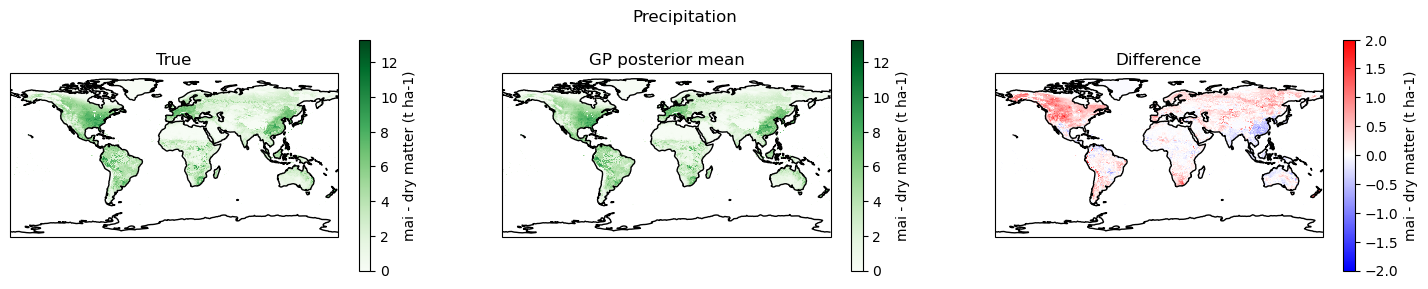

In [309]:
from matplotlib import colors

# Normalization for the difference plot
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Precipitation')

# Test
plt.subplot(131, projection=proj)
mai_truth.sel(time=slice(2050, None)).mean('time').plot(
    cmap="Greens", vmin=0, vmax=13.3, 
    cbar_kwargs={"label": 'mai - dry matter (t ha-1)'}
)
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_mai_data.sel(time=slice(2050, None)).mean('time').plot(
    cmap="Greens", vmin=0, vmax=13.3, 
    cbar_kwargs={"label": 'mai - dry matter (t ha-1)'}
)
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = mai_truth - posterior_mai_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050, None)).mean('time').plot(
    cmap="bwr", norm=diffnorm, 
    cbar_kwargs={"label": 'mai - dry matter (t ha-1)'}
)
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

plt.show()
